In [1]:
from hapin import *
#from pylab import plot
#import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import lmfit as lm
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
from scipy import interpolate
import sys

HAPI version: 1.2.2.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [2]:
db_begin('data')

Using data

23um01_HITEMP2010
                     Lines parsed: 275746
23um05_HITEMP2019
                     Lines parsed: 1632


In [3]:
od_nu=4284
do_nu=4286

nu_res=0.001

OmegaGrid = np.arange(od_nu, do_nu, nu_res)

print(OmegaGrid)

ela = 7.5

volfr_h2o=0.18
volfr_n2= 0.71
volfr_co2=0.10
volfr_co= 0.01

print(ela)

P_env = 1
T_env = 2100
P_ref = 1
T_ref = 296
#p_self=1
p_self = volfr_h2o*P_env

NSL_min = 1.0e-24

print(P_env,T_env,P_ref,T_ref,p_self)

cond = ('AND', ('BETWEEN','nu',od_nu,do_nu),('>=','sw',1e-45))

#select('23um01_HITEMP2010', ParameterNames=('nu','sw','delta_air','gamma_air','gamma_self','molec_id','local_iso_id','elower','n_air'),Conditions=cond,DestinationTableName='H2O-select')
select('23um01_HITEMP2010', Conditions=cond,DestinationTableName='H2O-select')

print(LOCAL_TABLE_CACHE['H2O-select']['data'].keys())
       
nue,sw,delta_air,gamma_air,gamma_self,molec_id,local_iso_id,elower,n_air = getColumns('H2O-select',['nu','sw','delta_air','gamma_air','gamma_self','molec_id','local_iso_id','elower','n_air'])

[4284.    4284.001 4284.002 ... 4285.997 4285.998 4285.999]
7.5
1 2100 1 296 0.18


In [4]:
nu, coef_HT = absorptionCoefficient_HT(
    SourceTables='H2O-select',
    Environment={'T': T_env, 'p': P_env},
    OmegaGrid=OmegaGrid,
    Diluent={'self': volfr_h2o, 'air': volfr_n2, 'CO2': volfr_co2}
)
nu, coef_Voigt = absorptionCoefficient_Voigt(
    SourceTables='H2O-select',
    Environment={'T': T_env, 'p': P_env},
    OmegaGrid=OmegaGrid,
    Diluent={'self': volfr_h2o, 'air': volfr_n2, 'CO2': volfr_co2}
)

{'self': 0.18, 'air': 0.71, 'CO2': 0.1}
0.873989 seconds elapsed for abscoef; nlines = 348
{'self': 0.18, 'air': 0.71, 'CO2': 0.1}
0.636795 seconds elapsed for abscoef; nlines = 348


(4284.0, 4286.0)

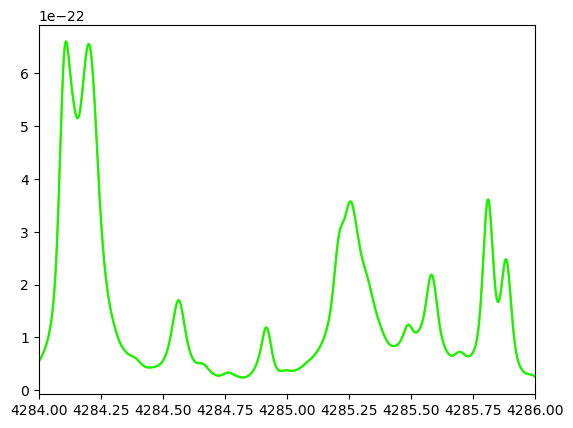

In [5]:
plt.plot(nu,coef_HT,'orange',nu, coef_Voigt,'lime') # plot both profiles
plt.xlim(od_nu, do_nu)

In [6]:
sum_lor=np.zeros(len(nu))
sum_voi=np.zeros(len(nu))

lor=[np.zeros(len(nu))]*len(nue)
voi=[np.zeros(len(nu))]*len(nue)

nux=[np.zeros(len(nu))]*len(nue)
g2f=[np.zeros(len(nu))]*len(nue)

delta=np.zeros(len(nue))
gammaD=np.zeros(len(nue))
gammaL=np.zeros(len(nue))
gammaLD=np.zeros(len(nue))
gammaLD1=np.zeros(len(nue))
gammaLD2=np.zeros(len(nue))
n_self=np.zeros(len(nue))

sw_env=np.zeros(len(nue))
nsl=np.zeros(len(nue))
vline=np.zeros(len(nue))
dvline=np.zeros(len(nue))
a0=np.zeros(len(nue))
#mW=np.ones(len(nue))

#I0=np.ones(len(nue))
#I0 = []
#for i in range(len(nue)):
#    I0.append(PowerFit(nue[i]))

In [7]:
AvogN = 6.02214129e23
c2=1.43877
fSqrtMass = sqrt(molecularMass(molec_id[0],local_iso_id[0]))

Q_env = partitionSum(molec_id[0],local_iso_id[0],T_env)
Q_ref = partitionSum(molec_id[0],local_iso_id[0],T_ref)

print(Q_env, Q_ref)

n=-1

molec2atm = 7.34e21/T_env

#GammaCon = 0.155/0.04
#GammaCon = 1.0

5960.448 174.5812888


In [8]:
for i in range(len(nue)):
    sw_env[i] =  sw[i]*(Q_ref/Q_env)*(np.exp(-c2*elower[i]/T_env)/np.exp(-c2*elower[i]/T_ref))*((1-np.exp(-c2*nue[i]/T_env))/(1-np.exp(-c2*nue[i]/T_ref)))

    delta[i] = delta_air[i]*(P_env - p_self)
    gammaD[i] = nue[i]*(cSqrt2Ln2/cc)*sqrt(AvogN*cBolts)*sqrt(T_env)/fSqrtMass
    
    #n_self[i] = 0.5
    n_self[i] = n_air[i]
    
    #gamma_air[i] = GammaCon*gamma_air[i]
    
    gammaL[i] = (P_env-p_self)*gamma_air[i]*(T_ref/T_env)**n_air[i] + p_self*gamma_self[i]*(T_ref/T_env)**n_self[i]
    
#def PROFILE_VOIGT(Nu,GammaD,Gamma0,Delta0,WnGrid,YRosen=0.0,Sw=1.0): 
    # Voigt profile based on HTP.
    # Input parameters:
    #      Nu        : Unperturbed line position in cm-1 (Input).
    #      GammaD    : Doppler HWHM in cm-1 (Input)
    #      Gamma0    : Speed-averaged line-width in cm-1 (Input).       
    #      Delta0    : Speed-averaged line-shift in cm-1 (Input).
    #      WnGrid    : Current WaveNumber of the Computation in cm-1 (Input).
    #      YRosen    : 1st order (Rosenkranz) line mixing coefficients in cm-1 (Input)
    
    voi[i] = PROFILE_VOIGT(nue[i],gammaD[i],gammaL[i],delta[i],nu) # calc Voigt
    
    #gammaLD1[i] = (gammaL[i]+np.sqrt(gammaL[i]**2 + (gammaD[i]/2)**2))/2
    #gammaLD1[i] = (gammaL[i]/2+np.sqrt((gammaL[i]/4)**2 + gammaD[i]**2))/2
    #gammaLD2[i] = np.sqrt(gammaL[i]**2 + gammaD[i]**2)
    #gammaLD[i] = (gammaLD1[i] + gammaLD2[i])/2

    gammaLD[i]= (0.5346*gammaL[i] + np.sqrt(0.2166*gammaL[i]**2 + 8*np.log(2)*gammaD[i]**2))/2

    lor[i] = PROFILE_LORENTZ(nue[i],gammaLD[i],delta[i],nu) # calc Lorentz
    
    nsl[i] = sw_env[i]*p_self*ela
    print(nue[i]+delta[i], sw_env[i], gammaL[i], gammaD[i], T_env, P_env)

    if nsl[i] > NSL_min:
        n=n+1
        sum_voi = sum_voi + voi[i]*sw_env[i]*p_self
        sum_lor = sum_lor + lor[i]*sw_env[i]*p_self
        vline[n] = nue[i]+delta[i]
        dvline[n] = gammaLD[i]
        elower[n] = elower[i]
        a0[n] = nsl[i]*molec2atm/(np.pi*dvline[n])
#        mW[n] = I0[i]
        #print("i=", i, nue[i]+delta[i], nsl[i], gammaLD[i], T_env, P_env)
#        print("n=", n, mW[n], vline[n], elower[n], a0[n], dvline[n], T_env, P_env) 
        print("n=", n, vline[n], elower[n], a0[n], dvline[n], T_env, P_env)

4283.98752692 6.687952995650807e-26 0.03898103112065936 0.016566086291835414 2100 1
4284.003188680001 9.643615246937714e-25 0.29185854219275104 0.01656612063821107 2100 1
n= 0 4284.003188680001 6149.4077 9.742317023120359e-06 0.1486751133022191 2100 1
4284.0091569999995 3.379423857357147e-25 0.043867515606763656 0.016566145220502225 2100 1
4284.0329 2.7083560212303015e-26 0.012814390227656822 0.01656620167817894 2100 1
4284.054647999999 1.1791855318800727e-24 0.033199030991258496 0.016566249628534504 2100 1
n= 1 4284.054647999999 9067.1982 5.93261910019321e-05 0.029853574410489827 2100 1
4284.04995 6.901499214012923e-28 0.03712111953065321 0.01656626760991784 2100 1
4284.043906780001 9.710139603941184e-27 0.05796700762797674 0.016566276967971107 2100 1
4284.090468 8.921979303465338e-27 0.01996635188197093 0.0165664325359392 2100 1
4284.08574292 8.691681093084548e-27 0.040351135075125194 0.016566435648845346 2100 1
4284.0936 1.3495829162798693e-26 0.012669300528013582 0.0165664364029033

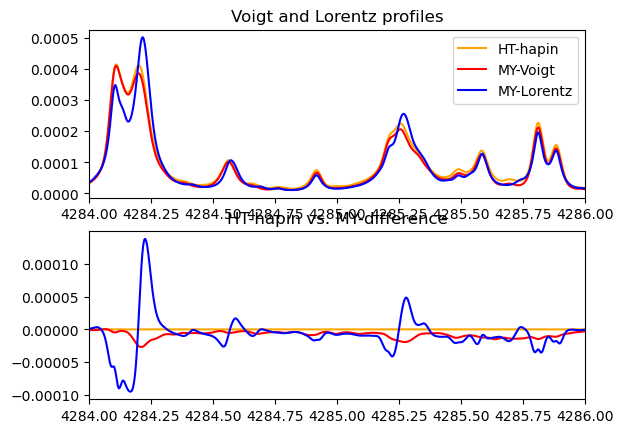

In [9]:
coef=coef_HT

my_voi_atm = sum_voi * molec2atm
my_lor_atm = sum_lor * molec2atm

diff_voi = my_voi_atm-(coef*molec2atm*p_self)
reldiff_voi = 100*diff_voi/(coef*molec2atm*p_self)  # calc difference

diff_lor = my_lor_atm-(coef*molec2atm*p_self)
reldiff_lor = 100*diff_lor/(coef*molec2atm*p_self)   # calc difference

plt.subplot(2,1,1) # upper panel
#plt.plot(nu,coef_air*molec2atm*p_self,'orange',nu,sum_voi_atm,'red') # plot both profiles
plt.plot(nu,coef*molec2atm*p_self,'orange',nu,my_voi_atm,'red',nu,my_lor_atm,'blue') # plot both profiles
plt.xlim(od_nu, do_nu)
plt.legend(['HT-hapin','MY-Voigt','MY-Lorentz']) # show legend
plt.title('Voigt and Lorentz profiles') # show title
plt.subplot(2,1,2) # lower panel
plt.xlim(od_nu, do_nu)
plt.plot(nu, coef_HT-coef_Voigt,'orange') # plot difference
plt.title('HT-hapin vs. MY-difference') # show title
plt.plot(nu, diff_voi,'red',nu, diff_lor,'blue') # plot difference
plt.title('HT-hapin vs. MY-difference') # show title
plt.show() # show all figures